In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from scipy import sparse
import pickle

In [33]:
import os
PATH = os.getcwd()
PATH

'/Users/pleng/python/mlps/Project/01_00_Data_cleaning_&_EDA_train/STAR_model'

In [34]:

# Load the data from 01_Data_Cleaning output
df_train = pd.read_pickle(PATH + "/cleaned_train_dataset.pkl")
df_valid = pd.read_pickle(PATH + "/cleaned_validation_dataset.pkl")
df_train.info()
# Combine datasets and sort
df_combined = pd.concat([df_train, df_valid], axis=0)
df_combined = df_combined.sort_values(by=['geo_value', 'time_value'])
print(f"Combined data shape: {df_combined.shape}")


<class 'pandas.core.frame.DataFrame'>
Index: 11075 entries, 47 to 15134
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   time_value                            11075 non-null  datetime64[ns]
 1   geo_value                             11075 non-null  object        
 2   smoothed_wspent_time_1d               11075 non-null  float64       
 3   smoothed_wtested_14d                  11075 non-null  float64       
 4   smoothed_wpublic_transit_1d           11075 non-null  float64       
 5   smoothed_wcovid_vaccinated_or_accept  11075 non-null  float64       
 6   smoothed_wworried_become_ill          11075 non-null  float64       
 7   smoothed_wvaccine_likely_govt_health  11075 non-null  float64       
 8   smoothed_wshop_1d                     11075 non-null  float64       
 9   smoothed_wwork_outside_home_1d        11075 non-null  float64       
 10  sm

In [35]:
target_variable = 'smoothed_wcovid_vaccinated'

In [36]:

# Function to create spatial weight matrix based on geographic proximity
def create_spatial_weights(df):
    """
    Create a spatial weights matrix based on geographic coordinates
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with geo_value
        
    Returns:
    --------
    scipy.sparse.csr_matrix
        Spatial weights matrix (row-normalized)
    dict
        Mapping of geo_value to matrix index
    """
    # Get unique geo values
    geo_values = df['geo_value'].unique()
    n_regions = len(geo_values)
    
    # Create mapping of geo_value to matrix index
    geo_to_idx = {geo: idx for idx, geo in enumerate(geo_values)}
    
    # Get state for each geo_value
    geo_state = df[['geo_value', 'state']].drop_duplicates().set_index('geo_value')['state']
        
    # Create adjacency based on same state
    W = np.zeros((n_regions, n_regions))
    for i, geo_i in enumerate(geo_values):
        state_i = geo_state.get(geo_i, "")
        for j, geo_j in enumerate(geo_values):
            if i != j:
                state_j = geo_state.get(geo_j, "")
                if state_i == state_j and state_i != "":
                    W[i, j] = 1
    
    # Row-normalize weights
    row_sums = W.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    W_normalized = W / row_sums[:, np.newaxis]
    
    # Convert to sparse matrix for efficiency
    W_sparse = sparse.csr_matrix(W_normalized)
    
    return W_sparse, geo_to_idx


In [37]:
# Create spatial weights matrix
W, geo_to_idx = create_spatial_weights(df_combined)

In [38]:
# Function to implement spatial lag for a given date
def spatial_lag(df, date, variable, W, geo_to_idx):
    """
    Calculate spatial lag for a given variable at a specific date
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with data
    date : datetime
        Date for which to calculate spatial lag
    variable : str
        Variable for which to calculate spatial lag
    W : scipy.sparse.csr_matrix
        Spatial weights matrix
    geo_to_idx : dict
        Mapping of geo_value to matrix index
        
    Returns:
    --------
    pd.Series
        Spatial lag values indexed by geo_value
    """
    # Get data for the specific date
    date_data = df[df['time_value'] == date]
    
    # Create a vector of values in the order expected by W
    n_regions = len(geo_to_idx)
    x = np.zeros(n_regions)
    
    for idx, row in date_data.iterrows():
        geo = row['geo_value']
        if geo in geo_to_idx:
            x[geo_to_idx[geo]] = row[variable]
    
    # Calculate spatial lag: W * x
    lag = W.dot(x)
    
    # Convert back to Series with geo_value index
    lag_series = pd.Series(index=geo_to_idx.keys(), data=[lag[geo_to_idx[geo]] for geo in geo_to_idx.keys()])
    
    return lag_series


In [39]:
def create_spatiotemporal_features(df, feature_list, W, geo_to_idx):
    """
    Create spatial and temporal lag features for multiple variables
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with time_value, geo_value, and features
    feature_list : list
        List of feature names to create spatiotemporal features for
    W : scipy.sparse.csr_matrix
        Spatial weights matrix
    geo_to_idx : dict
        Mapping of geo_value to matrix index
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added spatiotemporal features
    """
    df_st = df.copy()
    
    print(f"Creating spatiotemporal features for: {feature_list}")
    
    # Create temporal lags n days for each feature
    for feature in feature_list:
        for lag in [1, 2, 7]:
            df_st[f'{feature}_t{lag}'] = df_st.groupby('geo_value')[feature].shift(lag)
    
    # Create spatial lags for each feature and date
    all_dates = sorted(df['time_value'].unique())
    
    for feature in feature_list:
        print(f"Creating spatial lags for {feature}...")
        spatial_lags = {}
        
        for date in all_dates:
            spatial_lags[date] = spatial_lag(df, date, feature, W, geo_to_idx)
        
        # Create spatial lag column for this feature
        spatial_lag_col = f'{feature}_spatial_lag'
        df_st[spatial_lag_col] = np.nan
        
        for idx, row in df_st.iterrows():
            date = row['time_value']
            geo = row['geo_value']
            if date in spatial_lags and geo in spatial_lags[date].index:
                df_st.at[idx, spatial_lag_col] = spatial_lags[date][geo]
        
        # Create temporal lag of spatial lag (t-1)
        df_st[f'{feature}_spatial_lag_t1'] = df_st.groupby('geo_value')[spatial_lag_col].shift(1)
        
        # Create spatiotemporal interaction feature (temporal lag * spatial lag)
        df_st[f'{feature}_st_interaction'] = df_st[f'{feature}_t1'] * df_st[f'{feature}_spatial_lag_t1']

        interaction_values = df_st[f'{feature}_st_interaction'].values.reshape(-1, 1)
        
        # Apply scaling
        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(interaction_values)
        
        # Replace with scaled values
        df_st[f'{feature}_st_interaction'] = scaled_values

        # Remove null values
        df_st = df_st.dropna()
    
    return df_st

In [40]:
# feature_list = [
#     'smoothed_wcovid_vaccinated',       # Main target variable
#     'smoothed_wshop_1d',
#     'smoothed_wwork_outside_home_1d',
#     'smoothed_wspent_time_1d',
#     'smoothed_wrestaurant_1d',
#     'smoothed_wworried_become_ill',     # Worry about COVID
#     'smoothed_wcovid_vaccinated_or_accept',  # Vaccination acceptance
#     'smoothed_wwork_outside_home_1d',   # Outside activity
#     'smoothed_wcli'                     # COVID-like illness reports
# ]

# This list has better evaluation score (features chosen randomly)
feature_list = [
    'smoothed_wcovid_vaccinated',       # Main target variable
    'smoothed_wworried_become_ill',     # Worry about COVID
    'smoothed_wcovid_vaccinated_or_accept',  # Vaccination acceptance
    'smoothed_wwork_outside_home_1d',   # Outside activity
    'smoothed_wcli'                     # COVID-like illness reports
]

# Create spatiotemporal features
df_st = create_spatiotemporal_features(df_combined, feature_list, W, geo_to_idx)
df_st.info()

Creating spatiotemporal features for: ['smoothed_wcovid_vaccinated', 'smoothed_wworried_become_ill', 'smoothed_wcovid_vaccinated_or_accept', 'smoothed_wwork_outside_home_1d', 'smoothed_wcli']
Creating spatial lags for smoothed_wcovid_vaccinated...
Creating spatial lags for smoothed_wworried_become_ill...
Creating spatial lags for smoothed_wcovid_vaccinated_or_accept...
Creating spatial lags for smoothed_wwork_outside_home_1d...
Creating spatial lags for smoothed_wcli...
<class 'pandas.core.frame.DataFrame'>
Index: 8202 entries, 58 to 15134
Data columns (total 57 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   time_value                                           8202 non-null   datetime64[ns]
 1   geo_value                                            8202 non-null   object        
 2   smoothed_wspent_time_1d                              8202 no

In [41]:

# Filter validation period only
val_dates = df_valid['time_value'].unique()
train_dates = df_train['time_value'].unique()

df_train_st = df_st[df_st['time_value'].isin(train_dates)].copy()
df_valid_st = df_st[df_st['time_value'].isin(val_dates)].copy()

print(f"Train data with spatiotemporal features: {df_train_st.shape}")
print(f"Validation data with spatiotemporal features: {df_valid_st.shape}")


Train data with spatiotemporal features: (5138, 57)
Validation data with spatiotemporal features: (3064, 57)


In [42]:
# Get common features for all models
def get_features(df_train):
    """Get common features for all models"""
    # Define base features for model
    features = [
        f'{target_variable}_t1',  # Temporal autoregressive term (t-1)
        f'{target_variable}_t2',  # Temporal autoregressive term (t-2)
        f'{target_variable}_t7',  # Weekly effect
        f'{target_variable}_spatial_lag_t1',         # Spatial lag
        f'{target_variable}_st_interaction',          # Spatiotemporal interaction
        'day',
        'week_of_month',
        'tuesday',
        'wednesday',
        'thursday',
        'friday',
        'saturday',
        'sunday'
    ]
    
    # Exclude metadata columns and the target variable itself
    excluded_cols = ['time_value', 'geo_value', target_variable, 'day_of_week', 'state', 'county_name']
    
    # Get potential additional predictors
    additional_features = [col for col in df_train.columns 
                          if col not in excluded_cols 
                          and not col.startswith(target_variable)
                          and (col.endswith('_t1') or col.endswith('_t2') or col.endswith('_t7') 
                          or col.endswith('lag') or col.endswith('lag_t1') or col.endswith('st_interaction'))]  # Focus on lag variables
    
    # Combine all features
    all_features = features + additional_features
    
    return all_features

In [43]:

# Function to fit OLS spatial-temporal autoregression model
def fit_star_ols(df_train, df_valid, target_variable):
    """
    Fit OLS Spatial-Temporal AutoRegressive (STAR) model
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Training data with spatiotemporal features
    df_valid : pd.DataFrame
        Validation data with spatiotemporal features
    target_variable : str
        Name of the target variable
        
    Returns:
    --------
    statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted model
    dict
        Model evaluation metrics
    pd.DataFrame
        Validation data with predictions
    """

    # Get common features
    features = get_features(df_train)

    # Prepare data for modeling
    X_train = df_train[features]
    y_train = df_train[target_variable]


    # Add constant
    X_train = sm.add_constant(X_train)

    # Fit model
    model = sm.OLS(y_train, X_train).fit()
    print("\nOLS Model Summary:")
    print(model.summary())


    # Make predictions on validation set
    X_valid = df_valid[features]
    X_valid = sm.add_constant(X_valid)

    # Ensure X_valid has the same columns as X_train
    for col in X_train.columns:
        if col not in X_valid.columns:
            X_valid[col] = 0

    # Align columns
    X_valid = X_valid[X_train.columns]

    df_valid['ols_prediction'] = model.predict(X_valid)

    # Evaluate model
    valid_mask = df_valid['ols_prediction'].notna()
    y_true = df_valid.loc[valid_mask, target_variable]
    y_pred = df_valid.loc[valid_mask, 'ols_prediction']

    # Calculate metrics
    metrics = {}
    metrics['rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['r2'] = r2_score(y_true, y_pred)
    metrics['mape'] = np.mean(np.abs((y_true - y_pred) / (y_true + 0.01))) * 100

    print(f"\nOLS Spatial-Temporal Autoregression Performance:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    
    return model, metrics, df_valid


In [44]:
ols_model, ols_metrics, df_valid_ols = fit_star_ols(df_train_st, df_valid_st, target_variable)


OLS Model Summary:
                                OLS Regression Results                                
Dep. Variable:     smoothed_wcovid_vaccinated   R-squared:                       0.922
Model:                                    OLS   Adj. R-squared:                  0.921
Method:                         Least Squares   F-statistic:                     2005.
Date:                        Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                                22:00:51   Log-Likelihood:                -8468.9
No. Observations:                        5138   AIC:                         1.700e+04
Df Residuals:                            5107   BIC:                         1.720e+04
Df Model:                                  30                                         
Covariance Type:                    nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.9

In [45]:

# Function to fit Ridge spatial-temporal autoregression model
def fit_star_ridge(df_train, df_valid, target_variable):
    """
    Fit Ridge Spatial-Temporal AutoRegressive (STAR) model
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Training data with spatiotemporal features
    df_valid : pd.DataFrame
        Validation data with spatiotemporal features
    target_variable : str
        Name of the target variable
        
    Returns:
    --------
    sklearn.linear_model.Ridge
        Fitted model
    dict
        Model evaluation metrics
    pd.DataFrame
        Validation data with predictions
    """
    # Get common features
    features = get_features(df_train.copy())
    df_valid = df_valid.copy()
    
    # Prepare data for modeling
    X_train = df_train[features]
    y_train = df_train[target_variable]
    
    # Grid search for optimal alpha
    alphas = np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    
    ridge_cv = GridSearchCV(
        Ridge(random_state=42),
        {'alpha': alphas},
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    ridge_cv.fit(X_train, y_train)
    
    best_alpha = ridge_cv.best_params_['alpha']
    print(f"\nBest alpha for Ridge regression: {best_alpha}")
    
    # Fit final model with best alpha
    ridge_model = Ridge(alpha=best_alpha, random_state=42)
    ridge_model.fit(X_train, y_train)
    
    # Print coefficients
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': ridge_model.coef_
    })
    coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)
    print("\nRidge Model Coefficients:")
    print(coef_df)
    
    # Make predictions on validation set
    X_valid = df_valid[features]
    
    df_valid['ridge_prediction'] = ridge_model.predict(X_valid)
    
    # Evaluate model
    valid_mask = df_valid['ridge_prediction'].notna()
    y_true = df_valid.loc[valid_mask, target_variable]
    y_pred = df_valid.loc[valid_mask, 'ridge_prediction']
    
    # Calculate metrics
    metrics = {}
    metrics['rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['r2'] = r2_score(y_true, y_pred)
    metrics['mape'] = np.mean(np.abs((y_true - y_pred) / (y_true + 0.01))) * 100
    
    print(f"\nRidge Spatial-Temporal Autoregression Performance:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    
    return ridge_model, metrics, df_valid, features


In [46]:
ridge_model, ridge_metrics, df_valid_ridge, ridge_features = fit_star_ridge(df_train_st, df_valid_st, target_variable)


Best alpha for Ridge regression: 100.0

Ridge Model Coefficients:
                                          Feature  Coefficient
0                   smoothed_wcovid_vaccinated_t1     0.960904
20                               smoothed_wcli_t2     0.116914
19                               smoothed_wcli_t1    -0.097969
4       smoothed_wcovid_vaccinated_st_interaction     0.088328
2                   smoothed_wcovid_vaccinated_t7    -0.078958
7                                         tuesday    -0.059956
9                                        thursday     0.052382
29                   smoothed_wcli_spatial_lag_t1     0.052062
21                               smoothed_wcli_t7    -0.047228
27  smoothed_wwork_outside_home_1d_st_interaction     0.045290
10                                         friday     0.044785
1                   smoothed_wcovid_vaccinated_t2     0.040893
28                      smoothed_wcli_spatial_lag    -0.038325
6                                   week_of_month  

In [47]:

# Function to fit Lasso spatial-temporal autoregression model
def fit_star_lasso(df_train, df_valid, target_variable):
    """
    Fit Lasso Spatial-Temporal AutoRegressive (STAR) model
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Training data with spatiotemporal features
    df_valid : pd.DataFrame
        Validation data with spatiotemporal features
    target_variable : str
        Name of the target variable
        
    Returns:
    --------
    sklearn.linear_model.Lasso
        Fitted model
    dict
        Model evaluation metrics
    pd.DataFrame
        Validation data with predictions
    """
    # Get common features
    features = get_features(df_train.copy())
    df_valid = df_valid.copy()
    
    # Prepare data for modeling
    X_train = df_train[features]
    y_train = df_train[target_variable]
    
    # Grid search for optimal alpha
    alphas = np.logspace(-3, 1, 5)  # [0.001, 0.01, 0.1, 1, 10]
    
    lasso_cv = GridSearchCV(
        Lasso(random_state=42, max_iter=10000),
        {'alpha': alphas},
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    lasso_cv.fit(X_train, y_train)
    
    best_alpha = lasso_cv.best_params_['alpha']
    print(f"\nBest alpha for Lasso regression: {best_alpha}")
    
    # Fit final model with best alpha
    lasso_model = Lasso(alpha=best_alpha, random_state=42, max_iter=10000)
    lasso_model.fit(X_train, y_train)
    
    # Print coefficients and identify which features were selected
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': lasso_model.coef_
    })
    
    # Show non-zero coefficients (features selected by Lasso)
    selected_features = coef_df[coef_df['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)
    print("\nLasso Model Selected Features and Coefficients:")
    print(selected_features)
    print(f"\nNumber of features selected by Lasso: {len(selected_features)}")
    
    # Make predictions on validation set
    X_valid = df_valid[features]
    
    df_valid['lasso_prediction'] = lasso_model.predict(X_valid)
    
    # Evaluate model
    valid_mask = df_valid['lasso_prediction'].notna()
    y_true = df_valid.loc[valid_mask, target_variable]
    y_pred = df_valid.loc[valid_mask, 'lasso_prediction']
    
    # Calculate metrics
    metrics = {}
    metrics['rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['r2'] = r2_score(y_true, y_pred)
    metrics['mape'] = np.mean(np.abs((y_true - y_pred) / (y_true + 0.01))) * 100
    
    print(f"\nLasso Spatial-Temporal Autoregression Performance:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    
    return lasso_model, metrics, df_valid, features


In [48]:
lasso_model, lasso_metrics, df_valid_lasso, lasso_features = fit_star_lasso(df_train_st, df_valid_st, target_variable)


Best alpha for Lasso regression: 0.1

Lasso Model Selected Features and Coefficients:
                                        Feature  Coefficient
0                 smoothed_wcovid_vaccinated_t1     0.991810
2                 smoothed_wcovid_vaccinated_t7    -0.043698
5                                           day     0.022502
23  smoothed_wworried_become_ill_spatial_lag_t1    -0.000472
3     smoothed_wcovid_vaccinated_spatial_lag_t1     0.000210

Number of features selected by Lasso: 5

Lasso Spatial-Temporal Autoregression Performance:
RMSE: 1.5166
MAE: 1.1542
R²: 0.8978
MAPE: 6.81%


In [49]:
# Fit all models
ols_model, ols_metrics, df_valid_ols = fit_star_ols(df_train_st, df_train_st, target_variable)
ridge_model, ridge_metrics, df_valid_ridge, ridge_features = fit_star_ridge(df_train_st, df_train_st, target_variable)
lasso_model, lasso_metrics, df_valid_lasso, lasso_features = fit_star_lasso(df_train_st, df_train_st, target_variable)

# Merge predictions from all models
df_valid_all = df_valid_ols.copy()
df_valid_all['ridge_prediction'] = df_valid_ridge['ridge_prediction']
df_valid_all['lasso_prediction'] = df_valid_lasso['lasso_prediction']



OLS Model Summary:
                                OLS Regression Results                                
Dep. Variable:     smoothed_wcovid_vaccinated   R-squared:                       0.922
Model:                                    OLS   Adj. R-squared:                  0.921
Method:                         Least Squares   F-statistic:                     2005.
Date:                        Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                                22:00:54   Log-Likelihood:                -8468.9
No. Observations:                        5138   AIC:                         1.700e+04
Df Residuals:                            5107   BIC:                         1.720e+04
Df Model:                                  30                                         
Covariance Type:                    nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.9

In [50]:

# Compare models
def compare_all_models(df_valid_all, target_variable, baseline_results_path=None):
    """
    Compare all models with baseline models
    
    Parameters:
    -----------
    df_valid_all : pd.DataFrame
        Validation data with all model predictions
    target_variable : str
        Name of the target variable
    baseline_results_path : str, optional
        Path to baseline models results
    """
    # Load baseline results if available
    if baseline_results_path:
        df_baseline = pd.read_pickle(baseline_results_path)
        
        # Merge with model predictions
        df_compare = pd.merge(
            df_baseline, 
            df_valid_all[['time_value', 'geo_value', 'ols_prediction', 'ridge_prediction', 'lasso_prediction']],
            on=['time_value', 'geo_value'],
            how='inner'
        )
    else:
        df_compare = df_valid_all.copy()

    # Drop rows with missing values
    df_compare = df_compare.dropna(subset=[
        target_variable, 'ols_prediction', 'ridge_prediction', 'lasso_prediction'
    ]).reset_index(drop=True)
    
    # Evaluate all models
    y_true = df_compare[target_variable]
    
    # Define all models to compare
    model_cols = {
        'ols_prediction': 'OLS STAR',
        'ridge_prediction': 'Ridge STAR',
        'lasso_prediction': 'Lasso STAR'
    }
    
    # Add baseline models if available
    baseline_cols = [col for col in df_compare.columns if col.startswith('baseline_')]
    for col in baseline_cols:
        if col == 'baseline_yesterday':
            model_cols[col] = 'Previous Day Value'
        elif col == 'baseline_3day_mean':
            model_cols[col] = '3-Day Rolling Mean'
        elif col == 'baseline_7day_mean':
            model_cols[col] = '7-Day Rolling Mean'
        elif col == 'baseline_trend':
            model_cols[col] = '7-Day Linear Trend'
        else:
            model_cols[col] = col.replace('_', ' ').title()
    
    print(model_cols)

    # Create summary table of performance metrics
    metrics_table = []
    
    for col, name in model_cols.items():
        if col in df_compare.columns:
            y_pred = df_compare[col]
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            mape = np.mean(np.abs((y_true - y_pred) / (y_true + 0.01))) * 100
            
            metrics_table.append({
                'Model': name,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'MAPE': mape
            })
    
    # Convert to DataFrame and sort by MAE
    metrics_df = pd.DataFrame(metrics_table).sort_values('MAE')
    print("\nModel Performance Comparison:")
    print(metrics_df)
    
    # Create comparison plot
    plt.figure(figsize=(12, 8))
    
    for col, name in model_cols.items():
        if col in df_compare.columns:
            y_pred = df_compare[col]
            mae = mean_absolute_error(y_true, y_pred)
            
            # Plot absolute errors
            abs_errors = np.abs(y_true - y_pred)
            sns.kdeplot(abs_errors, label=f"{name} (MAE: {mae:.4f})")
    
    plt.title("Comparison of Model Error Distributions")
    plt.xlabel("Absolute Error")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("all_models_comparison.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Bar chart of performance metrics
    for metric in ['MAE', 'RMSE', 'R²']:
        plt.figure(figsize=(10, 6))
        
        # Sort by the current metric (ascending for MAE/RMSE, descending for R²)
        if metric == 'R²':
            sorted_df = metrics_df.sort_values(metric, ascending=False)
        else:
            sorted_df = metrics_df.sort_values(metric)
        
        # Plot bar chart
        ax = sns.barplot(x='Model', y=metric, data=sorted_df)
        
        # Add value labels on top of bars
        for i, v in enumerate(sorted_df[metric]):
            ax.text(i, v, f"{v:.4f}", ha='center', va='bottom')
        
        plt.title(f"Model Comparison by {metric}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"model_comparison_{metric.replace('²', '2')}.png", dpi=300, bbox_inches='tight')
        plt.close()
    
    return metrics_df, df_compare


In [51]:

# Compare all models (with my own baseline model)
# metrics_df, df_comparison = compare_all_models(df_valid_all, target_variable, "baseline_models_results.pkl")
metrics_df, df_comparison = compare_all_models(df_valid_all, target_variable)


{'ols_prediction': 'OLS STAR', 'ridge_prediction': 'Ridge STAR', 'lasso_prediction': 'Lasso STAR'}

Model Performance Comparison:
        Model      RMSE       MAE        R²      MAPE
1  Ridge STAR  1.258109  0.920604  0.921693  7.536709
0    OLS STAR  1.257777  0.920778  0.921734  7.538735
2  Lasso STAR  1.264530  0.923302  0.920892  7.562302


In [52]:

# Save final results
df_comparison.to_pickle("star_models_comparison.pkl")

# Save all models for future use
models = {
    'ols': {
        'model': ols_model,
        'features': ols_model.model.exog_names if hasattr(ols_model.model, 'exog_names') else None
    },
    'ridge': {
        'model': ridge_model,
        'features': ridge_features
    },
    'lasso': {
        'model': lasso_model,
        'features': lasso_features
    },
    'geo_to_idx': geo_to_idx,
    'W': W,
    'metrics': metrics_df.to_dict()
}

with open('star_models.pkl', 'wb') as f:
    pickle.dump(models, f)

print("\nSpatial-Temporal Autoregression modeling with OLS, Ridge, and Lasso complete!")



Spatial-Temporal Autoregression modeling with OLS, Ridge, and Lasso complete!


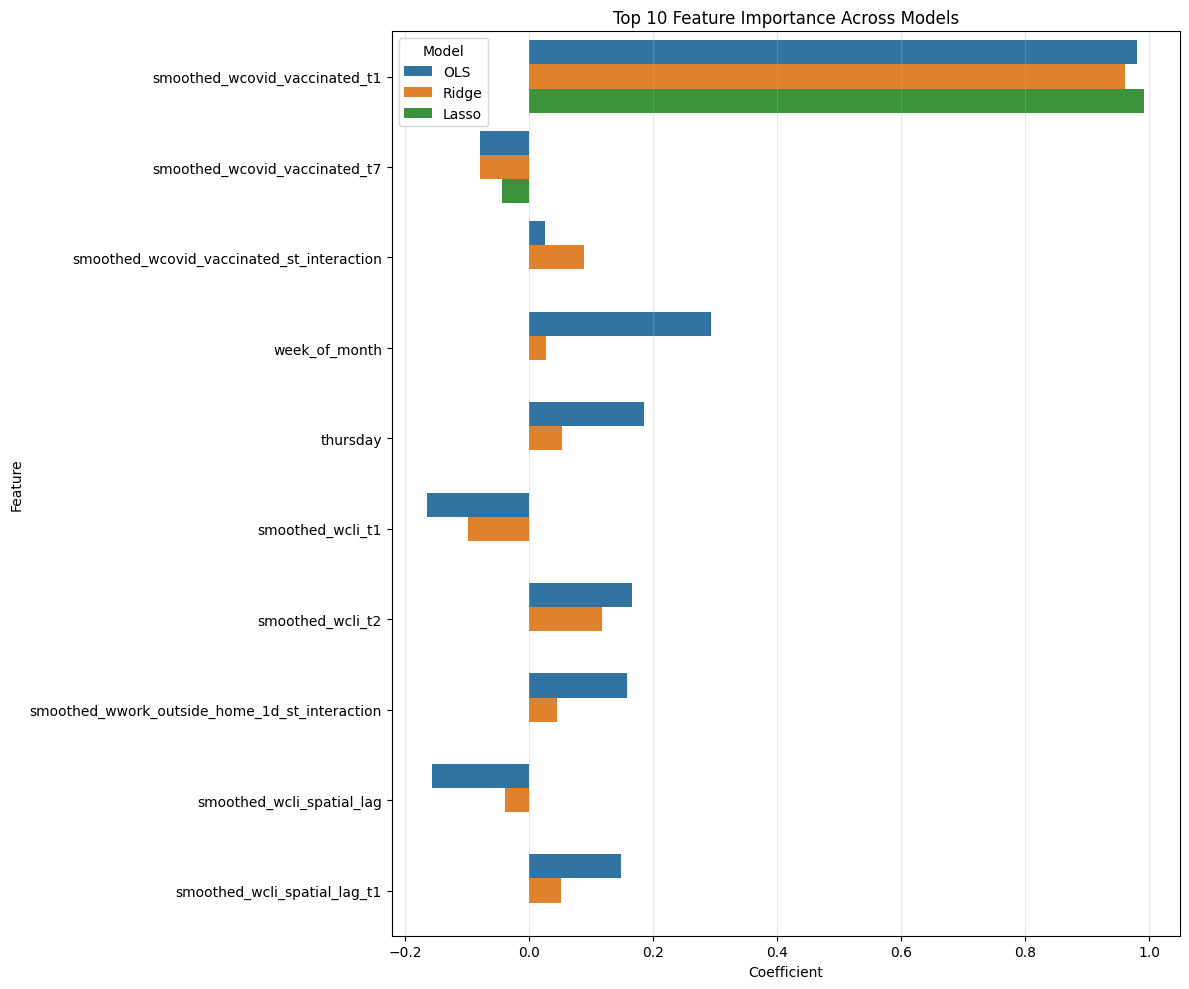

In [53]:

# Visualize feature importance for all models
def plot_feature_importance():
    """
    Plot feature importance for all models
    """
    plt.figure(figsize=(12, 10))
    
    # OLS coefficients
    ols_coef = pd.DataFrame({
        'Feature': ols_model.model.exog_names[1:],  # Skip constant
        'Coefficient': ols_model.params[1:],
        'Model': 'OLS'
    })
    
    # Ridge coefficients
    ridge_coef = pd.DataFrame({
        'Feature': ridge_features,
        'Coefficient': ridge_model.coef_,
        'Model': 'Ridge'
    })
    
    # Lasso coefficients
    lasso_coef = pd.DataFrame({
        'Feature': lasso_features,
        'Coefficient': lasso_model.coef_,
        'Model': 'Lasso'
    })
    
    # Combine coefficients
    all_coef = pd.concat([ols_coef, ridge_coef, lasso_coef])
    
    # Get top features by average absolute coefficient
    top_features = all_coef.groupby('Feature')['Coefficient'].apply(lambda x: np.mean(np.abs(x))).nlargest(10).index
    
    # Filter for top features
    all_coef_top = all_coef[all_coef['Feature'].isin(top_features)]
    
    # Plot
    sns.barplot(x='Coefficient', y='Feature', hue='Model', data=all_coef_top)
    
    plt.title('Top 10 Feature Importance Across Models')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig("feature_importance_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot feature importance
plot_feature_importance()

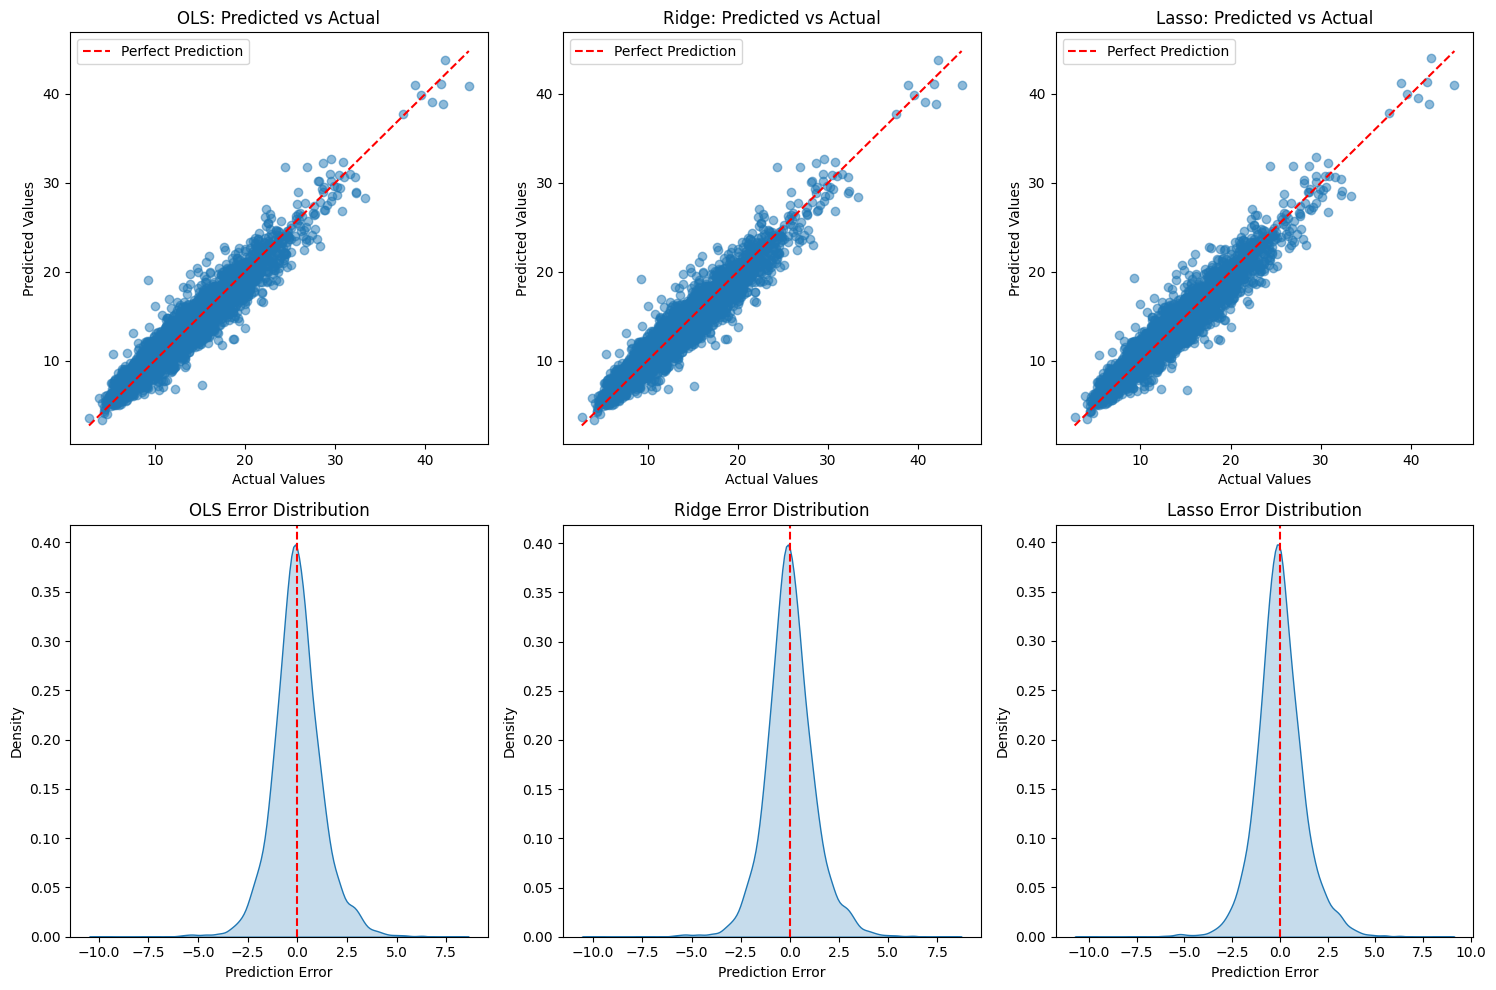


Model Comparison Metrics:

OLS Model:
MAE: 0.9208
RMSE: 1.2578
R²: 0.9217

RIDGE Model:
MAE: 0.9206
RMSE: 1.2581
R²: 0.9217

LASSO Model:
MAE: 0.9233
RMSE: 1.2645
R²: 0.9209


In [54]:
# Create visualization comparing predictions vs actual
plt.figure(figsize=(15, 10))

# Plot OLS predictions
plt.subplot(231)
plt.scatter(df_valid_all[target_variable], df_valid_all['ols_prediction'], alpha=0.5)
plt.plot([df_valid_all[target_variable].min(), df_valid_all[target_variable].max()], 
         [df_valid_all[target_variable].min(), df_valid_all[target_variable].max()], 
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('OLS: Predicted vs Actual')
plt.legend()

# Plot Ridge predictions 
plt.subplot(232)
plt.scatter(df_valid_all[target_variable], df_valid_all['ridge_prediction'], alpha=0.5)
plt.plot([df_valid_all[target_variable].min(), df_valid_all[target_variable].max()],
         [df_valid_all[target_variable].min(), df_valid_all[target_variable].max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge: Predicted vs Actual')
plt.legend()

# Plot Lasso predictions
plt.subplot(233)
plt.scatter(df_valid_all[target_variable], df_valid_all['lasso_prediction'], alpha=0.5)
plt.plot([df_valid_all[target_variable].min(), df_valid_all[target_variable].max()],
         [df_valid_all[target_variable].min(), df_valid_all[target_variable].max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso: Predicted vs Actual')
plt.legend()

# Plot error distributions
plt.subplot(234)
sns.kdeplot(df_valid_all[target_variable] - df_valid_all['ols_prediction'], 
            label='OLS Error', fill=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('OLS Error Distribution')

plt.subplot(235)
sns.kdeplot(df_valid_all[target_variable] - df_valid_all['ridge_prediction'], 
            label='Ridge Error', fill=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Ridge Error Distribution')

plt.subplot(236)
sns.kdeplot(df_valid_all[target_variable] - df_valid_all['lasso_prediction'], 
            label='Lasso Error', fill=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Lasso Error Distribution')

plt.tight_layout()
plt.show()

# Print model comparison metrics
print("\nModel Comparison Metrics:")
for model in ['ols', 'ridge', 'lasso']:
    pred_col = f'{model}_prediction'
    mae = mean_absolute_error(df_valid_all[target_variable], df_valid_all[pred_col])
    rmse = np.sqrt(mean_squared_error(df_valid_all[target_variable], df_valid_all[pred_col]))
    r2 = r2_score(df_valid_all[target_variable], df_valid_all[pred_col])
    print(f"\n{model.upper()} Model:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")